In [9]:
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 60)
pd.set_option('display.max_rows', 60)
pd.set_option('mode.chained_assignment',  None)

plt.rc('font',family='malgun gothic')

# 스마트카드 데이터
SMART_CARD = pd.read_csv('./data/SMART_CARD.csv', header = None)

# 공공데이터포털
getrouteinfoall = pd.read_csv('./data/getRouteInfoAll.csv', encoding = 'cp949', index_col = 0) # 전체 노선 기본정보 조회
getstationbyrouteall = pd.read_csv('./data/getStationByRouteAll.csv', encoding = 'cp949', index_col = 0) # 전체노선별경유정류소 정보 조회

# 정류장 데이터
bus_sttn = pd.read_csv('./data/bus_sttn.csv')

In [10]:
def smart_card_data_preprocessing(exdata):
    exdata.columns = ['SERIAL_NO', 'CARD_NO', 'GETON_YMD', 'GETON_TM', 'BUS_ROUTE_ID', 'BUS_CO_ID', 'BUS_CAR_ID', 'GETON_BUS_STTN_ID', 'GETOFF_BUS_STTN_ID',
                        'DRVR_ID', 'TRANSACTION_ID', 'TR_MEANS_TYPE', 'USR_TYPE', 'DRVN_START_YMD', 'DRVN_START_TM', 'GETOFF_YMD', 'GETOFF_TM', 'GETON_CALC_YMD',
                        'GETOFF_CALC_YMD', 'GETON_PAY', 'GETOFF_PAY', 'TRANSF_CNT', 'USR_CNT']
    exdata.drop(labels = ['SERIAL_NO', 'DRVR_ID','TRANSACTION_ID','USR_TYPE','DRVN_START_YMD','BUS_CO_ID','DRVN_START_TM','GETOFF_YMD','GETOFF_TM','GETON_CALC_YMD','GETOFF_CALC_YMD', 'GETON_PAY','GETOFF_PAY','TRANSF_CNT','GETOFF_BUS_STTN_ID'], axis = 1, inplace = True)


    exdata['GETON_TM'] = exdata['GETON_TM'].apply(lambda x: str(x).zfill(6)) # GETON_TM 컬럼 날짜형식으로 변환하기 위해 자릿수 맞춰주기

    # datetime 형식으로 변환 및 새로운 column 생성
    exdata['GETON_DATETIME'] = pd.to_datetime(exdata['GETON_YMD'].astype(str) + exdata['GETON_TM'].astype(str), format = '%Y%m%d%H%M%S')

    exdata['DAY'] = exdata['GETON_DATETIME'].dt.day
    exdata['WEEKDAY'] = exdata['GETON_DATETIME'].dt.weekday  

    # 급행/지선/간선만 필터링
    exdata = exdata[exdata['TR_MEANS_TYPE'].isin([675,676])]

    # 도시 노선만 사용하기 위해
    values_to_remove = [30300147, 30300148, 30300141, 30300137, 30300149, 30300103]
    exdata = exdata[~exdata['BUS_ROUTE_ID'].isin(values_to_remove)]

    # 평일만 추출
    weekday_values = [0, 1, 2, 3, 4]
    exdata = exdata[exdata['WEEKDAY'].isin(weekday_values)]

    # 6/6일 제거 / 6/19일 제거[결측치]
    exdata = exdata[exdata['DAY'] != 6]
    exdata = exdata[exdata['DAY'] != 19]

    # 비가 온 날 제거
    exdata = exdata[~exdata['DAY'].isin([26,29])]

    # 사용한 행 제거
    exdata.drop(labels = ['GETON_YMD','GETON_TM','TR_MEANS_TYPE','USR_CNT','WEEKDAY'], axis = 1, inplace = True)
    
    return exdata

In [11]:
SMART_CARD_DATA = smart_card_data_preprocessing(SMART_CARD)
SMART_CARD_DATA.head(2)

,CARD_NO,BUS_ROUTE_ID,BUS_CAR_ID,GETON_BUS_STTN_ID,GETON_DATETIME,DAY
3,804099084,30300053,130752377,8005978,2023-06-01 05:20:33,1
35,929954937,30300043,130759616,8001243,2023-06-01 05:30:22,1


### 시각화

In [47]:
SMART_CARD_DATA['GETON_HOUR'] = SMART_CARD_DATA['GETON_DATETIME'].dt.hour

# 출/퇴근 시간대만 필터링
SMART_CARD_DATA_ = SMART_CARD_DATA[SMART_CARD_DATA['GETON_HOUR'].isin([7,8,16,17,18])]
SMART_CARD_DATA_

,CARD_NO,BUS_ROUTE_ID,BUS_CAR_ID,GETON_BUS_STTN_ID,GETON_DATETIME,DAY,GETON_HOUR
16361,803929993,30300070,130752605,8002825,2023-06-01 07:00:00,1,7
16362,803166584,30300037,130759023,8005517,2023-06-01 07:00:00,1,7
16363,911563091,30300071,130759180,8002572,2023-06-01 07:00:00,1,7
16364,934924962,30300069,130759715,8003044,2023-06-01 07:00:00,1,7
16365,549151960,30300096,130752063,8002553,2023-06-01 07:00:00,1,7
...,...,...,...,...,...,...,...
10698195,745323770,30300077,130752010,8002434,2023-06-30 18:59:59,30,18
10698196,541380065,30300087,130759614,8002088,2023-06-30 18:59:59,30,18
10698198,918362716,30300054,130759382,8002452,2023-06-30 18:59:59,30,18
10698199,781295883,30300036,130759520,8002407,2023-06-30 18:59:59,30,18


In [116]:
getrouteinfoall[getrouteinfoall['ROUTE_NO']=='601']

,ALLO_INTERVAL,ALLO_INTERVAL_SAT,ALLO_INTERVAL_SUN,BUSSTOP_CNT,END_NODE_ID,END_STOP_ID,ORIGIN_END,ORIGIN_END_SAT,ORIGIN_END_SUN,ORIGIN_START,ORIGIN_START_SAT,ORIGIN_START_SUN,ROUTE_CD,ROUTE_NO,ROUTE_TP,RUN_DIST_HALF,RUN_TM,START_NODE_ID,START_STOP_ID,TURN_END,TURN_END_SAT,TURN_END_SUN,TURN_NODE_ID,TURN_START,TURN_START_SAT,TURN_START_SUN,TURN_STOP_ID
58,21,23,23,73,8007172.0,51590.0,2245,2245,2245,545,545,545,30300068,601,2,16.9795,72,8001803,51590.0,2240,2240,2240,8007565,540,540,540,46800.0


In [48]:
getrouteinfoall_merge_df = getrouteinfoall[['ALLO_INTERVAL','ROUTE_CD','ROUTE_NO']]

In [92]:
allo_interval_merge = SMART_CARD_DATA_.merge(getrouteinfoall_merge_df, left_on = 'BUS_ROUTE_ID', right_on = 'ROUTE_CD')
allo_interval_merge = allo_interval_merge[['ROUTE_NO','CARD_NO','ALLO_INTERVAL']]
bus_usage = allo_interval_merge.groupby("ROUTE_NO").size().reset_index(name="USAGE_COUNT")
bus_usage_merge = bus_usage.merge(getrouteinfoall_merge_df, left_on = 'ROUTE_NO', right_on = 'ROUTE_NO')
bus_usage_merge = bus_usage_merge[['ROUTE_NO','USAGE_COUNT','ALLO_INTERVAL']]
bus_usage_merge['ALLO_INTERVAL'] = bus_usage_merge['ALLO_INTERVAL'].astype(int)
bus_usage_merge['USAGE_COUNT'] = (bus_usage_merge['USAGE_COUNT']/18).astype(int)
bus_usage_merge_work = bus_usage_merge[bus_usage_merge['ROUTE_NO']!='2']

In [93]:
allo_interval_merge = SMART_CARD_DATA.merge(getrouteinfoall_merge_df, left_on = 'BUS_ROUTE_ID', right_on = 'ROUTE_CD')
allo_interval_merge = allo_interval_merge[['ROUTE_NO','CARD_NO','ALLO_INTERVAL']]
bus_usage = allo_interval_merge.groupby("ROUTE_NO").size().reset_index(name="USAGE_COUNT")
bus_usage_merge = bus_usage.merge(getrouteinfoall_merge_df, left_on = 'ROUTE_NO', right_on = 'ROUTE_NO')
bus_usage_merge = bus_usage_merge[['ROUTE_NO','USAGE_COUNT','ALLO_INTERVAL']]
bus_usage_merge['ALLO_INTERVAL'] = bus_usage_merge['ALLO_INTERVAL'].astype(int)
bus_usage_merge['USAGE_COUNT'] = (bus_usage_merge['USAGE_COUNT']/18).astype(int)
bus_usage_merge_all = bus_usage_merge[bus_usage_merge['ROUTE_NO']!='2']

산점도 시각화

In [94]:
# import plotly.express as px

# # Plotly로 산점도 그래프 그리기
# fig = px.scatter(
#     bus_usage_merge,
#     x="USAGE_COUNT",
#     y="ALLO_INTERVAL",
#     color="ROUTE_NO",
#     color_continuous_scale="viridis",
#     labels={"USAGE_COUNT": "버스 이용량", "ALLO_INTERVAL": "배차간격 (분)"},
#     title="버스 노선별 이용량에 따른 배차간격",
#     trendline="ols"  # 선형 회귀선 추가
# )

# fig.update_coloraxes(colorbar_title="버스 노선번호")

# # Customize x-axis tick labels to display numbers without abbreviation
# fig.update_xaxes(tickformat="d")

# # Customize y-axis tick labels to display numbers without abbreviation
# fig.update_yaxes(tickformat="d")

# fig.show()


회귀선 시각화

In [95]:
# import seaborn as sns
# # seaborn을 사용하여 산점도 그래프와 선형 회귀선 그리기
# plt.figure(figsize=(50, 30))
# sns.scatterplot(data=bus_usage_merge, x="USAGE_COUNT", y="ALLO_INTERVAL", hue="ROUTE_NO", palette="viridis")
# sns.regplot(data=bus_usage_merge, x="USAGE_COUNT", y="ALLO_INTERVAL", scatter=False, color='black', line_kws={"color": "red"})
# plt.xlabel("이용량")
# plt.ylabel("배차간격 (분)")
# plt.title("이용량에 따른 배차간격")

# # 데이터 포인트에 레이블 달기
# for route, usage, interval in zip(bus_usage_merge["ROUTE_NO"], bus_usage_merge["USAGE_COUNT"], bus_usage_merge["ALLO_INTERVAL"]):
#     plt.annotate(route,
#                  xy=(usage, interval),
#                  xytext=(-5, 0),
#                  textcoords='offset points',
#                  fontsize=10)  # 레이블 텍스트 크기 조정

# # 범례 제거
# plt.legend().remove()

# plt.show()

c:\Users\user\anaconda3\envs\yangjunghyun\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Glyph 8722 (\N{MINUS SIGN}) missing from current font.



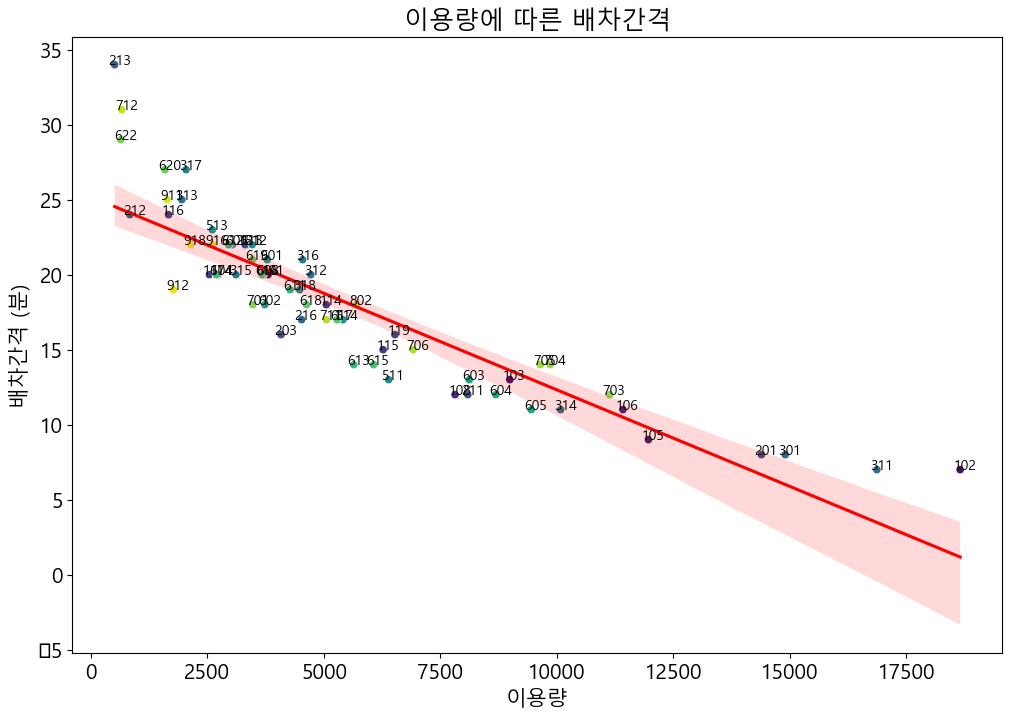

In [99]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 그래프 크기 설정
plt.figure(figsize=(12, 8))

# 산점도 그래프와 회귀선 그리기
sns.scatterplot(data=bus_usage_merge_all, x="USAGE_COUNT", y="ALLO_INTERVAL", hue="ROUTE_NO", palette="viridis")
sns.regplot(data=bus_usage_merge_all, x="USAGE_COUNT", y="ALLO_INTERVAL", scatter=False, color='black', line_kws={"color": "red"})

# 데이터 포인트에 레이블 달기
for route, usage, interval in zip(bus_usage_merge_all["ROUTE_NO"], bus_usage_merge_all["USAGE_COUNT"], bus_usage_merge_all["ALLO_INTERVAL"]):
    plt.annotate(route,
                 xy=(usage, interval),
                 xytext=(-5, 0),
                 textcoords='offset points',
                 fontsize=10)

# X, Y 축 레이블 및 타이틀 설정
plt.xlabel("이용량")
plt.ylabel("배차간격 (분)")
plt.title("이용량에 따른 배차간격")

# 회귀선의 방정식 계산
a, b = np.polyfit(bus_usage_merge_all["USAGE_COUNT"], bus_usage_merge_all["ALLO_INTERVAL"], 1)

# 회귀선과의 거리 계산 및 데이터프레임에 추가
distances = []
for x, y in zip(bus_usage_merge_all["USAGE_COUNT"], bus_usage_merge_all["ALLO_INTERVAL"]):
    y_pred = a * x + b
    distance = y - y_pred
    distances.append(distance)

# 거리를 데이터프레임에 추가
bus_usage_merge_all["Distance"] = distances

# 범례 제거
plt.legend().remove()

plt.show()

# 거리가 추가된 데이터프레임 출력
# print(bus_usage_merge_all.head())

c:\Users\user\anaconda3\envs\yangjunghyun\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Glyph 8722 (\N{MINUS SIGN}) missing from current font.



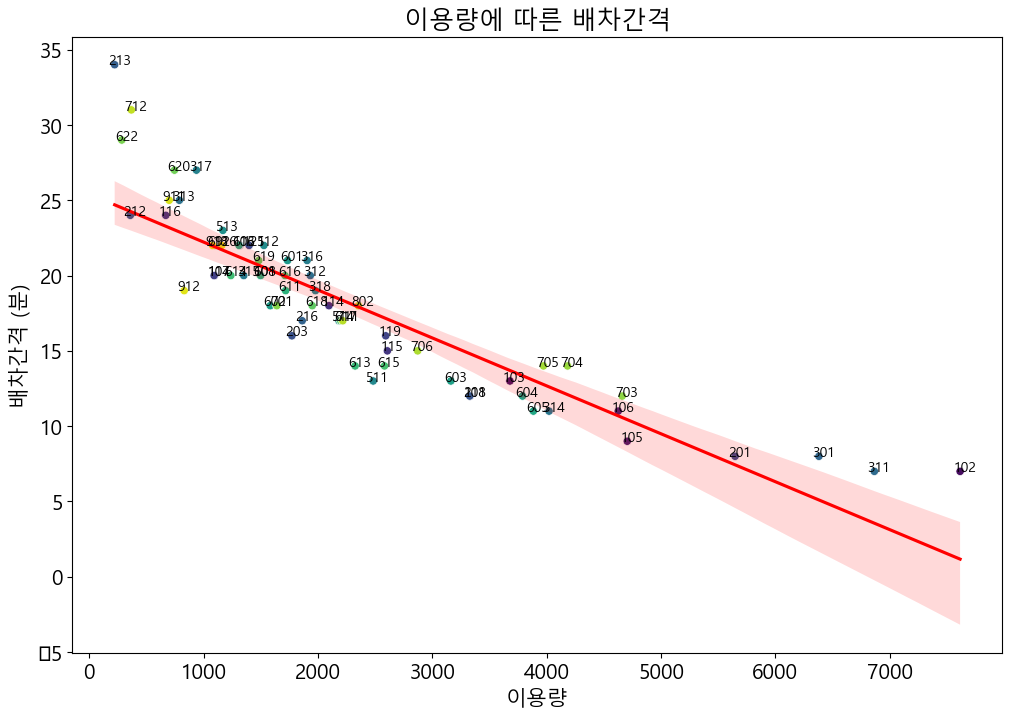

In [100]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 그래프 크기 설정
plt.figure(figsize=(12, 8))

# 산점도 그래프와 회귀선 그리기
sns.scatterplot(data=bus_usage_merge_work, x="USAGE_COUNT", y="ALLO_INTERVAL", hue="ROUTE_NO", palette="viridis")
sns.regplot(data=bus_usage_merge_work, x="USAGE_COUNT", y="ALLO_INTERVAL", scatter=False, color='black', line_kws={"color": "red"})

# 데이터 포인트에 레이블 달기
for route, usage, interval in zip(bus_usage_merge_work["ROUTE_NO"], bus_usage_merge_work["USAGE_COUNT"], bus_usage_merge_work["ALLO_INTERVAL"]):
    plt.annotate(route,
                 xy=(usage, interval),
                 xytext=(-5, 0),
                 textcoords='offset points',
                 fontsize=10)

# X, Y 축 레이블 및 타이틀 설정
plt.xlabel("이용량")
plt.ylabel("배차간격 (분)")
plt.title("이용량에 따른 배차간격")

# 회귀선의 방정식 계산
a, b = np.polyfit(bus_usage_merge_work["USAGE_COUNT"], bus_usage_merge_work["ALLO_INTERVAL"], 1)

# 회귀선과의 거리 계산 및 데이터프레임에 추가
distances = []
for x, y in zip(bus_usage_merge_work["USAGE_COUNT"], bus_usage_merge_work["ALLO_INTERVAL"]):
    y_pred = a * x + b
    distance = y - y_pred
    distances.append(distance)

# 거리를 데이터프레임에 추가
bus_usage_merge_work["Distance"] = distances

# 범례 제거
plt.legend().remove()

plt.show()

# 거리가 추가된 데이터프레임 출력
# print(bus_usage_merge_work.head())

In [103]:
bus_usage_merge_work.columns = ['ROUTE_NO_WORK','USAGE_COUNT_WORK','ALLO_INTERVAL_WORK','Distance_WORK']

In [104]:
display(bus_usage_merge_work.head(2))
display(bus_usage_merge_all.head(2))

,ROUTE_NO_WORK,USAGE_COUNT_WORK,ALLO_INTERVAL_WORK,Distance_WORK
0,101,1499,20,-0.635066
1,102,7616,7,5.828176


,ROUTE_NO,USAGE_COUNT,ALLO_INTERVAL,Distance
0,101,3803,20,-0.303277
1,102,18652,7,5.819909


In [1]:
bus_linear_line = pd.concat([bus_usage_merge_all, bus_usage_merge_work], axis = 1)
bus_linear_line = bus_linear_line[['ROUTE_NO','ALLO_INTERVAL','Distance','Distance_WORK']]
bus_linear_line['DISTANCE'] = bus_linear_line['Distance'] - bus_linear_line['Distance_WORK']
bus_linear_line['DISTANCE'] = bus_linear_line['DISTANCE'].abs()
bus_linear_line

NameError: name 'pd' is not defined

In [111]:
bus_linear_line.sort_values('DISTANCE', ascending = False).head(30)

,ROUTE_NO,ALLO_INTERVAL,Distance,Distance_WORK,DISTANCE
22,301,8,1.987921,2.898618,0.910697
16,201,8,1.329833,0.566338,0.763495
38,604,12,-2.010874,-1.348680,0.662194
4,105,9,-0.794475,-1.434125,0.639650
37,603,13,-1.742369,-2.343686,0.601317
43,612,22,0.608496,0.069930,0.538565
53,701,18,-2.724401,-2.186428,0.537973
31,511,13,-3.970338,-4.504147,0.533809
47,616,20,-0.469408,0.042664,0.512072
64,918,22,-0.442384,0.028567,0.470951


In [52]:
# # 확대한 그래프
# import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt

# # 그래프 크기 설정
# plt.figure(figsize=(12, 8))

# # 전체 데이터에 대한 산점도와 회귀선 그리기
# sns.scatterplot(data=bus_usage_merge, x="USAGE_COUNT", y="ALLO_INTERVAL", hue="ROUTE_NO", palette="viridis")
# sns.regplot(data=bus_usage_merge, x="USAGE_COUNT", y="ALLO_INTERVAL", scatter=False, color='black', line_kws={"color": "red"})

# # 데이터 포인트에 레이블 달기
# for route, usage, interval in zip(bus_usage_merge["ROUTE_NO"], bus_usage_merge["USAGE_COUNT"], bus_usage_merge["ALLO_INTERVAL"]):
#     plt.annotate(route,
#                  xy=(usage, interval),
#                  xytext=(-5, 0),
#                  textcoords='offset points',
#                  fontsize=13)

# # X, Y 축 레이블 및 타이틀 설정
# plt.xlabel("이용량")
# plt.ylabel("배차간격 (분)")
# plt.title("이용량에 따른 배차간격")

# # 이용량이 6000에서 14000 사이인 데이터만 추출
# filtered_data = bus_usage_merge[(bus_usage_merge["USAGE_COUNT"] >= 6000) & (bus_usage_merge["USAGE_COUNT"] <= 14000)]

# # # 이용량이 6000에서 14000 사이인 데이터 중에서 노선 번호만 추출하여 범례 표시
# # legend_labels = filtered_data["ROUTE_NO"].unique()
# # plt.legend(labels=legend_labels)
# plt.legend().set_visible(False)

# # 이용량이 6000에서 14000 사이인 부분만 확대해서 보여주기
# plt.xlim(6000, 14000)
# plt.ylim(8, 20)  # 배차간격에 따라 범위 조절

# # Y 축 눈금 설정 (1분 간격)
# plt.yticks(np.arange(8, 21, 1))
# plt.rc('font', size = 15)
# plt.show()


---